In [1]:
import pandas as pd
import numpy as np
import sys
import os
import datetime as dt
sys.path.append('./Others/Data_Science/Project')

In [2]:
Temp2023 = pd.read_csv('Temp2023.csv', encoding='cp949')
sub2023 = pd.read_csv('sub2023.csv', encoding='cp949')
Temp2024 = pd.read_csv('Temp2024.csv', encoding='cp949')
sub2024 = pd.read_csv('sub2024.csv', encoding='cp949')

In [3]:
def create_trainingset(Tempdat, subdat, stn):
    # input : Tempdat - 일시, 기온(°C), 강수량(mm)
    #          subdat - 일자, 시간(가로축), 승하차구분, 호선, 승차인원
    # output : Df - 일자, 시간, 기온(°C), 강수량(mm), 승하차구분, 호선, 승차인원
    Temparr = Tempdat[['일시','기온(°C)','강수량(mm)']] 
    Temparr['일시'] = pd.to_datetime(Temparr['일시'])
    Temparr['강수량(mm)'] = Temparr['강수량(mm)'].fillna(0)
    # subdat은 6시이전 ~ 24시까지이므로 1,2,3,4시 데이터를 Tempdat에서 제외
    hours_to_exclude = [1, 2, 3, 4]
    Temparr = Temparr[~Temparr['일시'].dt.hour.isin(hours_to_exclude)]
    Temparr['시간'] = Temparr['일시'].dt.hour
    Temparr['일시'] = Temparr['일시'].dt.date
    # Temp의 1월 1일 00시 데이터 제거
    Temparr = Temparr.drop(Temparr.index[0])
    
    subdat_stn = subdat[(subdat['역명']==stn)] # stn에 해당하는 역 데이터만 추출출
    subdat_stn['수송일자'] = pd.to_datetime(subdat_stn['수송일자'])
    passenger = subdat_stn.iloc[:,6:].values.flatten() # 승차인원의 시간별 데이터를 세로로 펴기기
    hour = np.arange(0,len(passenger)) % 20 + 5 # 시간은 5시부터 시작하므로 0~19를 5~24로 변환
    hour[hour == 24] = 0 # 24시를 0시로 변환
    
    # subdat_stn에서 시간을 세로축에 넣어 데이터를 재구성, 5시~24시까지의 데이터가 추가되므로 20개씩 반복복
    subdat_stn_New = pd.DataFrame({
        '일자': subdat_stn['수송일자'].values.repeat(20),
        '시간': hour,
        '승하차구분' : subdat_stn['승하차구분'].values.repeat(20),
        '호선' : subdat_stn['호선'].values.repeat(20),
        '승차인원': passenger
    })
    # 24시의 일자를 다음날로 변경 (예: 2023-01-01 24시 -> 2023-01-02 00시)
    mask = subdat_stn_New['시간'] == 0
    subdat_stn_New.loc[mask, '일자'] = subdat_stn_New.loc[mask, '일자'] + pd.Timedelta(days=1)
    # subdat_stn_New의 일자를 date 타입으로 변환 (비교를 위해)
    subdat_stn_New['일자'] = subdat_stn_New['일자'].dt.date

    # 일자와 시간을 기준으로 left join
    subdat_stn_New_arr = subdat_stn_New.merge(
        Temparr,
        left_on=['일자', '시간'],
        right_on=['일시', '시간'],
        how='left'
    )
    subdat_stn_New_arr = subdat_stn_New_arr.drop(columns=['일시'])
    subdat_stn_New_arr['일자'] = pd.to_datetime(subdat_stn_New_arr['일자'])
    subdat_stn_New_arr = subdat_stn_New_arr.dropna()
    return subdat_stn_New_arr

In [4]:
df1 = create_trainingset(Temp2023, sub2023, '강남')
df2 = create_trainingset(Temp2024, sub2024, '강남')

/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_3591/227782802.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temparr['일시'] = pd.to_datetime(Temparr['일시'])
/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_3591/227782802.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temparr['강수량(mm)'] = Temparr['강수량(mm)'].fillna(0)
/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_3591/227782802.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [14]:
df1.head()

,일자,시간,승하차구분,호선,승차인원
0,2023-01-01,5,승차,2호선,1015
1,2023-01-01,6,승차,2호선,909
2,2023-01-01,7,승차,2호선,592
3,2023-01-01,8,승차,2호선,506
4,2023-01-01,9,승차,2호선,585


In [15]:
# 안 쓰는 코드
"""
Temp2023 = pd.read_csv('Temp2023.csv', encoding='cp949')
Temp2023 = Temp2023[['일시','기온(°C)','강수량(mm)']]
# nan을 0으로 채우기
Temp2023['강수량(mm)'] = Temp2023['강수량(mm)'].fillna(0)
# 일시에서 시간을 따로 추출하여 행으로 추가함
# 일시는 날짜 성분만 남김
Temp2023['일시'] = pd.to_datetime(Temp2023['일시'])
hours_to_exclude = [1, 2, 3, 4]
Temp2023 = Temp2023[~Temp2023['일시'].dt.hour.isin(hours_to_exclude)]
Temp2023['시간'] = Temp2023['일시'].dt.hour
Temp2023['일시'] = Temp2023['일시'].dt.date
Temp2023 = Temp2023.drop(Temp2023.index[0])

# 시간이 0인 행들의 일시에서 하루 빼기
# 먼저 일시를 다시 datetime으로 변환 (현재 date 타입이므로)
#Temp2023['일시'] = pd.to_datetime(Temp2023['일시'])

# 시간이 0인 행들의 일시에서 1일 빼기
#mask = Temp2023['시간'] == 0
#Temp2023.loc[mask, '일시'] = Temp2023.loc[mask, '일시'] - pd.Timedelta(days=1)

# 필요하다면 다시 date 타입으로 변환
#Temp2023['일시'] = Temp2023['일시'].dt.date

# 인덱스 재설정 (선택사항)
#Temp2023 = Temp2023.reset_index(drop=True)

# 시청 먼저 해보기기
sub2023_cityhall = sub2023[(sub2023['역명']=='시청')]
sub2023_cityhall['수송일자'] = pd.to_datetime(sub2023_cityhall['수송일자'])
# 새로운 데이터프레임 생성
# 시간을 새로운 column으으로 추가할 것임
passenger = sub2023_cityhall.iloc[:,6:].values.flatten()
hour = np.arange(0,len(passenger)) % 20 + 5
hour[hour == 24] = 0
sub2023df = pd.DataFrame({
    '일자': sub2023_cityhall['수송일자'].values.repeat(20),
    '시간': hour,
    '승하차구분' : sub2023_cityhall['승하차구분'].values.repeat(20),
    '호선' : sub2023_cityhall['호선'].values.repeat(20),
    '승차인원': passenger
})
mask = sub2023df['시간'] == 0
sub2023df.loc[mask, '일자'] = sub2023df.loc[mask, '일자'] + pd.Timedelta(days=1)
# sub2023df의 일자를 date 타입으로 변환 (비교를 위해)
sub2023df['일자_date'] = sub2023df['일자'].dt.date
# 일자와 시간을 기준으로 left join
sub2023dfarr = sub2023df.merge(
    Temp2023,
    left_on=['일자_date', '시간'],
    right_on=['일시', '시간'],
    how='left'
)
sub2023dfarr = sub2023dfarr.drop(columns=['일자_date', '일시'])
sub2023dfarr['일자'] = pd.to_datetime(sub2023dfarr['일자'])
"""

"\nTemp2023 = pd.read_csv('Temp2023.csv', encoding='cp949')\nTemp2023 = Temp2023[['일시','기온(°C)','강수량(mm)']]\n# nan을 0으로 채우기\nTemp2023['강수량(mm)'] = Temp2023['강수량(mm)'].fillna(0)\n# 일시에서 시간을 따로 추출하여 행으로 추가함\n# 일시는 날짜 성분만 남김\nTemp2023['일시'] = pd.to_datetime(Temp2023['일시'])\nhours_to_exclude = [1, 2, 3, 4]\nTemp2023 = Temp2023[~Temp2023['일시'].dt.hour.isin(hours_to_exclude)]\nTemp2023['시간'] = Temp2023['일시'].dt.hour\nTemp2023['일시'] = Temp2023['일시'].dt.date\nTemp2023 = Temp2023.drop(Temp2023.index[0])\n\n# 시간이 0인 행들의 일시에서 하루 빼기\n# 먼저 일시를 다시 datetime으로 변환 (현재 date 타입이므로)\n#Temp2023['일시'] = pd.to_datetime(Temp2023['일시'])\n\n# 시간이 0인 행들의 일시에서 1일 빼기\n#mask = Temp2023['시간'] == 0\n#Temp2023.loc[mask, '일시'] = Temp2023.loc[mask, '일시'] - pd.Timedelta(days=1)\n\n# 필요하다면 다시 date 타입으로 변환\n#Temp2023['일시'] = Temp2023['일시'].dt.date\n\n# 인덱스 재설정 (선택사항)\n#Temp2023 = Temp2023.reset_index(drop=True)\n\n# 시청 먼저 해보기기\nsub2023_cityhall = sub2023[(sub2023['역명']=='시청')]\nsub2023_cityhall['수송일자'] = pd.to_datetime(sub

In [5]:
# 주말과 휴일 기입, 주말 = 1, 휴일 = 2, 주말인데 휴일인 날도 2로 처리
weekend = df1['일자'].dt.weekday >=5
df1['주말'] = 0
df1['주말'][weekend]=1
vacation_2023 = np.array([dt.date(2023,1,1), dt.date(2023,1,21), dt.date(2023,1,22), dt.date(2023,1,23),
                     dt.date(2023,1,24), dt.date(2023,3,1), dt.date(2023,5,5),dt.date(2023,5,27),
                     dt.date(2023,5,29), dt.date(2023,6,6), dt.date(2023,8,15),
                     dt.date(2023,9,28), dt.date(2023,9,29), dt.date(2023,9,30),
                      dt.date(2023,10,2), dt.date(2023,10,3),dt.date(2023,10,9),
                      dt.date(2023,12,25)])
df1['주말'][df1['일자'].dt.date.isin(vacation_2023)] = 2 # 

weekend = df2['일자'].dt.weekday >=5
df2['주말'] = 0
df2['주말'][weekend]=1
vacation_2024 = np.array([dt.date(2024,1,1),dt.date(2024,2,9), dt.date(2024,2,10),
                          dt.date(2024,2,11),dt.date(2024,2,12),
                          dt.date(2024,3,1),dt.date(2024,4,10),dt.date(2024,5,5),
                          dt.date(2024,5,6),dt.date(2024,5,15),dt.date(2024,6,6),
                          dt.date(2024,8,15),dt.date(2024,9,16), dt.date(2024,9,17),
                          dt.date(2024,9,18),dt.date(2024,10,3),dt.date(2024,10,9),
                          dt.date(2024,12,25)])
df2['주말'][df2['일자'].dt.date.isin(vacation_2024)] = 2 #


/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_3591/7626604.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df1['주말'][weekend]=1
/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_3591/7626604.py:4: SettingWithCopyWar

In [6]:
# ...existing code...
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 범주형 변수 인코딩
df_ml = pd.concat([df1, df2], ignore_index=True)
#df_ml['승차인원'] = np.log10(df_ml['승차인원']+1)  # 승차인원 로그 변환
df_ml['승하차구분'] = df_ml['승하차구분'].astype('category').cat.codes
df_ml['호선'] = df_ml['호선'].astype('category').cat.codes

# 입력 변수와 출력 변수 지정
X = df_ml[['시간', '승하차구분', '호선', '주말']]
y = df_ml['승차인원']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
np.sqrt(mse)

639.6014784724019

In [13]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 11, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# 기본 랜덤 포레스트 모델
rf = RandomForestRegressor(random_state=42)

# GridSearchCV 설정
# CV는 Cross-validation 폴드 수, n_jobs=-1은 모든 CPU 코어 사용
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, 
                           n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# GridSearchCV를 사용한 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델로 예측 및 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
#mse = mean_squared_error(10**y_test-1, 10**y_pred-1)
print(f"튜닝 후 테스트 MSE: {mse:.2f}")

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_dept

In [96]:
new_X = pd.DataFrame([[8, 1, 0, 0.9, 0, 0]], columns=['시간', '승하차구분', '호선', '기온(°C)', '강수량(mm)', '주말'])
pred_y = model.predict(new_X)
print(f"예측된 승차인원: {10**pred_y[0]+1:.0f}")  # 로그 변환을 되돌림
print(f"예측된 승차인원: {pred_y[0]:.0f}") 

예측된 승차인원: 8890
예측된 승차인원: 4


In [22]:
df_ml['호선']==0

0        True
1        True
2        True
3        True
4        True
         ... 
29231    True
29232    True
29233    True
29234    True
29235    True
Name: 호선, Length: 29236, dtype: bool

In [26]:
test1 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==2) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']==0)]['승차인원']
from scipy.stats import anderson
result = anderson(test1)
result.statistic, result.critical_values, result.significance_level

(0.6351547341855834,
 array([0.523, 0.596, 0.715, 0.834, 0.992]),
 array([15. , 10. ,  5. ,  2.5,  1. ]))

In [24]:
test2 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==1) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']==0)]['승차인원']
test3 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==0) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']==0)]['승차인원']
test4 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==2) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']>0)]['승차인원']
test5 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==1) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']>0)]['승차인원']
test6 = df_ml[(df_ml['시간']== 9) & (df_ml['주말']==0) & (df_ml['승하차구분']==0) & (df_ml['호선']==0) & (df_ml['강수량(mm)']>0)]['승차인원']

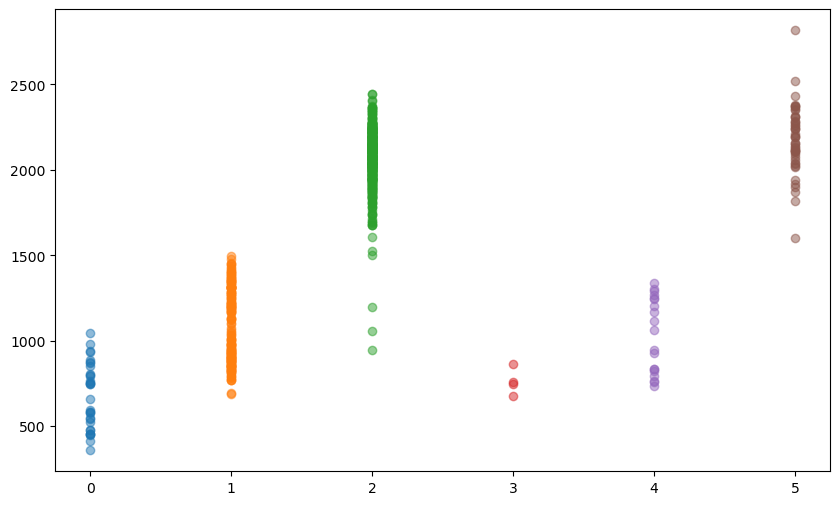

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(test1.values*0, test1.values, alpha=0.5)
plt.scatter(np.ones_like(test2), test2.values, alpha=0.5)
plt.scatter(np.ones_like(test3)*2, test3.values, alpha=0.5)
plt.scatter(np.ones_like(test4)*3, test4.values, alpha=0.5)
plt.scatter(np.ones_like(test5)*4, test5.values, alpha=0.5)
plt.scatter(np.ones_like(test6)*5, test6.values, alpha=0.5)

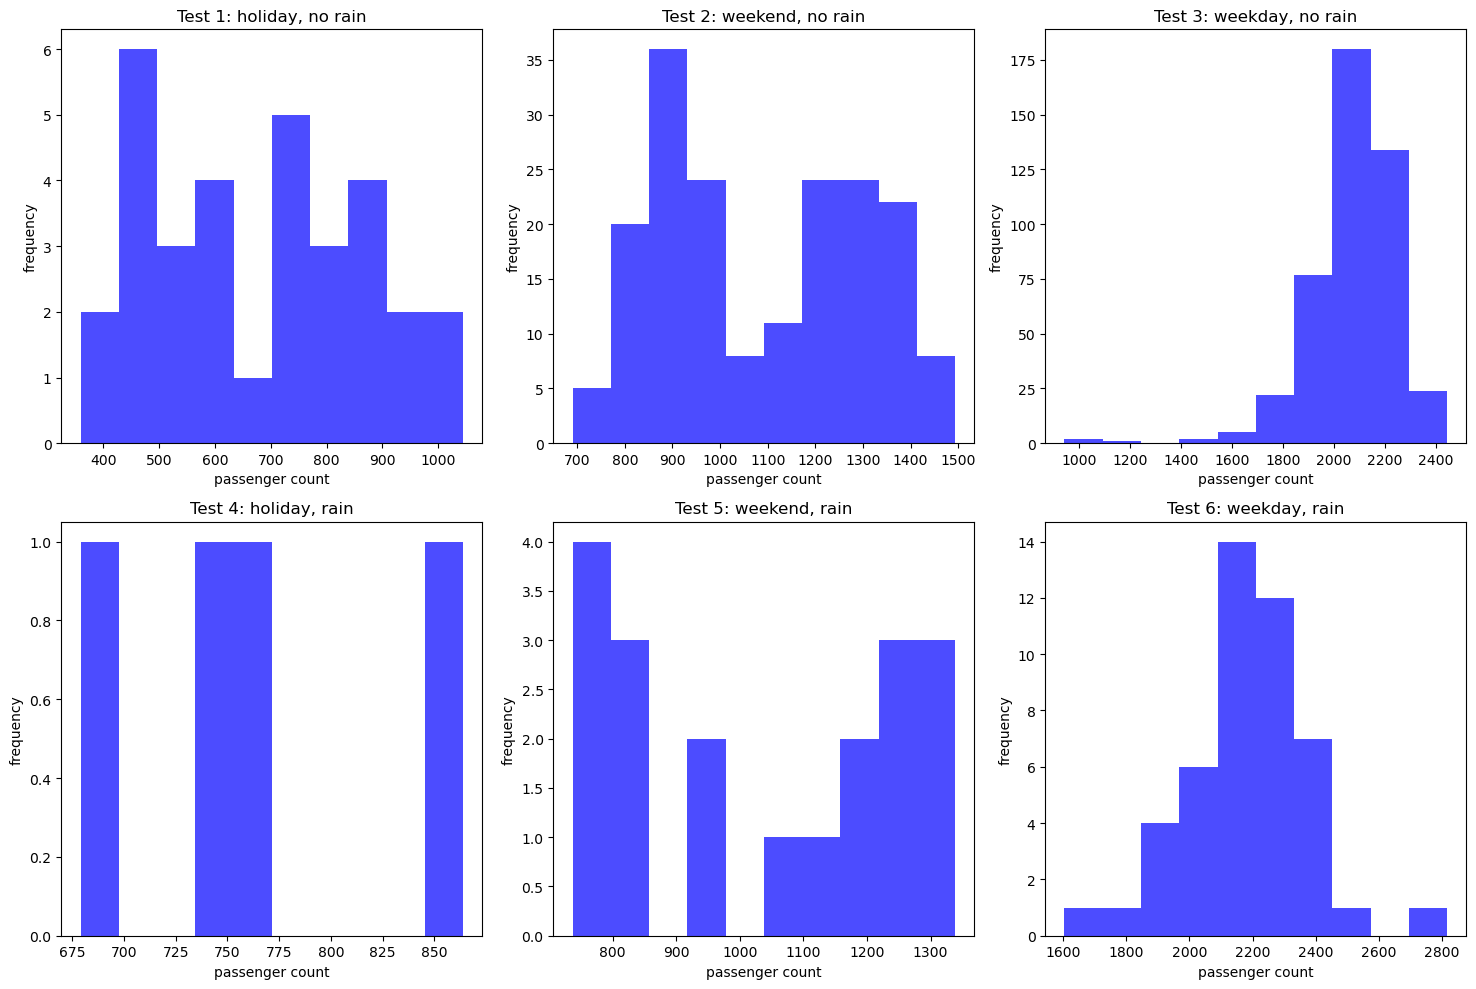

In [36]:


import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten() # 2x3 배열을 1차원 배열로 만듭니다.

datasets = [test1, test2, test3, test4, test5, test6]
titles = ['Test 1: holiday, no rain', 'Test 2: weekend, no rain', 'Test 3: weekday, no rain', 
          'Test 4: holiday, rain', 'Test 5: weekend, rain', 'Test 6: weekday, rain']

for i, data in enumerate(datasets):
    axes[i].hist(data, bins=10, alpha=0.7, color='blue')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('passenger count')
    axes[i].set_ylabel('frequency')

plt.tight_layout() # 서브플롯 간 간격 자동 조정
plt.show()
